# Mentor-Mentee Matching: ML Model Development

This notebook walks through:
1. **Data Loading & Exploration**
2. **Feature Engineering**
3. **Baseline Model**
4. **Advanced Models**
5. **Evaluation & Deployment**

In [1]:
# Install required packages (run once)
# !pip install sqlalchemy pandas numpy scikit-learn matplotlib seaborn sentence-transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, ndcg_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cosine
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

print(" Imports successful!")

 Imports successful!


## 1. Data Loading & Exploration

In [3]:
# Database connection
from dotenv import load_dotenv
import os
load_dotenv()
DB_URL = os.getenv("DATABASE_URL")
if not DB_URL:
    raise RuntimeError("DATABASE_URL not set. Add it to .env or environment variables before running this notebook.")
engine = create_engine(DB_URL)

print("Loading data from database...")

Loading data from database...


In [4]:
# Load mentors
with engine.connect() as conn:
    mentors_df = pd.read_sql_query(text("SELECT * FROM mentors WHERE active = TRUE"), conn)
    print(f"Loaded {len(mentors_df)} active mentors")
    
    # Load mentees
    mentees_df = pd.read_sql_query(text("SELECT * FROM mentees WHERE active = TRUE"), conn)
    print(f"Loaded {len(mentees_df)} active mentees")
    
    # Load interactions (our training data)
    interactions_df = pd.read_sql_query(text("""
        SELECT * FROM interactions 
        WHERE status IN ('completed', 'cancelled')
        AND mentor_accepted IS NOT NULL 
        AND mentee_accepted IS NOT NULL
    """), conn)
    print(f"Loaded {len(interactions_df)} interactions")

print("\n✓ Data loaded successfully!")

Loaded 175 active mentors
Loaded 274 active mentees
Loaded 331 interactions

✓ Data loaded successfully!


In [5]:
# Quick data overview
print("=" * 60)
print("MENTORS OVERVIEW")
print("=" * 60)
print(mentors_df.head())
print(f"\nShape: {mentors_df.shape}")
print(f"\nColumns: {list(mentors_df.columns)}")

MENTORS OVERVIEW
   mentor_id             name                         email  \
0        335       Sandy Owen         garellano@example.net   
1        201  Alexandra Craig         michael29@example.org   
2        203   Shawn Williams          donald23@example.org   
3        204       Julie Hunt  rodriguezmichael@example.com   
4        206     George Brown        rileybarry@example.net   

                                              skills  \
0                     [Tableau, SQL, KPIs, Power BI]   
1                   [Cloud Architecture, Serverless]   
2  [React, CI/CD, HTML/CSS, Linux, AWS, Node.js, ...   
3  [Terraform, Stakeholder Management, Docker, Ro...   
4  [Penetration Testing, SIEM, Roadmapping, Agile...   

                               domains  experience_years            industry  \
0                 [Business Analytics]                14           Education   
1                    [Cloud Computing]                 7  Telecommunications   
2            [DevOps, Web D

In [6]:
print("=" * 60)
print("MENTEES OVERVIEW")
print("=" * 60)
print(mentees_df.head())
print(f"\nShape: {mentees_df.shape}")

MENTEES OVERVIEW
   mentee_id               name                       email  \
0        161  Mr. Alex Mitchell      leonedward@example.org   
1        162    Gwendolyn Silva       mmitchell@example.org   
2        163      James Randall         laurawu@example.com   
3        164     Stephanie Park         aclarke@example.net   
4        165     Chad Macdonald  kruegerjessica@example.org   

                            current_skills  \
0                                 [Pandas]   
1  [Usability Testing, Interaction Design]   
2                                   [KPIs]   
3                              [B2B Sales]   
4                       [Terraform, Linux]   

                                               goals  \
0  Build foundational skills in Data Science and ...   
1   Learn the basics of UX Design and build projects   
2  Navigate career growth and strategic decisions...   
3        Become an expert in Sales and mentor others   
4      Transition into DevOps from a different 

In [7]:
print("=" * 60)
print("INTERACTIONS OVERVIEW")
print("=" * 60)
print(interactions_df.head())
print(f"\nShape: {interactions_df.shape}")

# Check for our target variable
print("\nTarget Variable Distribution:")
print(interactions_df['successful_match'].value_counts())
print(f"\nSuccess Rate: {interactions_df['successful_match'].mean():.2%}")

INTERACTIONS OVERVIEW
   interaction_id  mentor_id  mentee_id          match_date  mentor_accepted  \
0               1        255        432 2025-03-03 06:27:24             True   
1               3        325        391 2025-03-31 19:03:48            False   
2               4        257        267 2025-06-11 04:59:51             True   
3               5        215        236 2024-07-07 13:51:11            False   
4               6        299        312 2024-08-27 03:09:36            False   

   mentee_accepted     status  meetings_held  duration_weeks  mentor_rating  \
0             True  completed              6            16.0            4.0   
1             True  cancelled              0             NaN            NaN   
2             True  completed              7            15.0            5.0   
3             True  cancelled              0             NaN            NaN   
4            False  cancelled              0             NaN            NaN   

   mentee_rating  over

### Exploratory Data Analysis

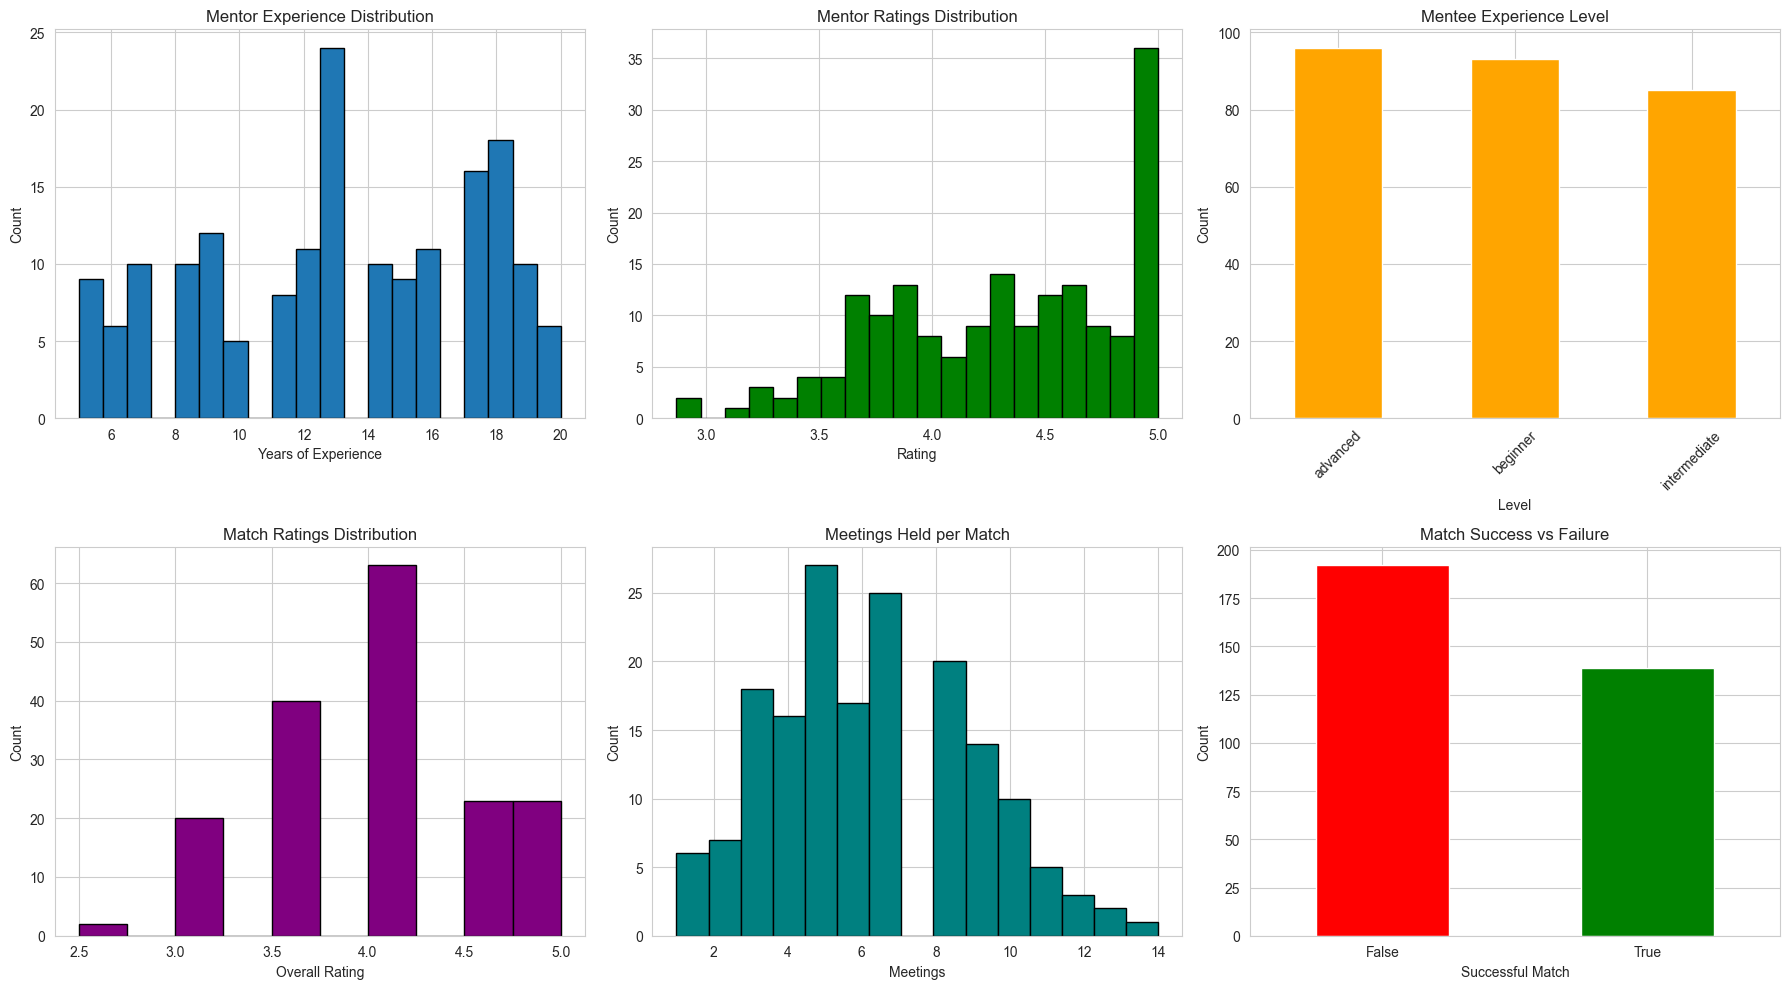

In [8]:
# Visualize key distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Mentor experience distribution
axes[0, 0].hist(mentors_df['experience_years'], bins=20, edgecolor='black')
axes[0, 0].set_title('Mentor Experience Distribution')
axes[0, 0].set_xlabel('Years of Experience')
axes[0, 0].set_ylabel('Count')

# Mentor ratings
axes[0, 1].hist(mentors_df['rating'], bins=20, edgecolor='black', color='green')
axes[0, 1].set_title('Mentor Ratings Distribution')
axes[0, 1].set_xlabel('Rating')
axes[0, 1].set_ylabel('Count')

# Mentee level distribution
mentees_df['current_level'].value_counts().plot(kind='bar', ax=axes[0, 2], color='orange')
axes[0, 2].set_title('Mentee Experience Level')
axes[0, 2].set_xlabel('Level')
axes[0, 2].set_ylabel('Count')
axes[0, 2].tick_params(axis='x', rotation=45)

# Match outcomes
completed_interactions = interactions_df[interactions_df['status'] == 'completed']
if len(completed_interactions) > 0:
    axes[1, 0].hist(completed_interactions['overall_rating'].dropna(), bins=10, edgecolor='black', color='purple')
    axes[1, 0].set_title('Match Ratings Distribution')
    axes[1, 0].set_xlabel('Overall Rating')
    axes[1, 0].set_ylabel('Count')

# Meetings held
if len(completed_interactions) > 0:
    axes[1, 1].hist(completed_interactions['meetings_held'].dropna(), bins=15, edgecolor='black', color='teal')
    axes[1, 1].set_title('Meetings Held per Match')
    axes[1, 1].set_xlabel('Meetings')
    axes[1, 1].set_ylabel('Count')

# Success vs failure
interactions_df['successful_match'].value_counts().plot(kind='bar', ax=axes[1, 2], color=['red', 'green'])
axes[1, 2].set_title('Match Success vs Failure')
axes[1, 2].set_xlabel('Successful Match')
axes[1, 2].set_ylabel('Count')
axes[1, 2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 2. Feature Engineering

We'll create features that capture similarity and compatibility between mentors and mentees.

In [9]:
def calculate_domain_overlap(mentor_domains, mentee_domains):
    """Calculate overlap between mentor expertise and mentee interests"""
    if not mentor_domains or not mentee_domains:
        return 0
    overlap = len(set(mentor_domains) & set(mentee_domains))
    # Normalize by mentee's desired domains
    return overlap / len(mentee_domains) if mentee_domains else 0

def calculate_skill_overlap(mentor_skills, mentee_skills):
    """Calculate skill overlap"""
    if not mentor_skills or not mentee_skills:
        return 0
    overlap = len(set(mentor_skills) & set(mentee_skills))
    total = len(set(mentor_skills) | set(mentee_skills))
    return overlap / total if total > 0 else 0

def calculate_availability_compatibility(mentor_hours, mentee_hours):
    """Calculate availability compatibility (0-1 scale)"""
    diff = abs(mentor_hours - mentee_hours)
    # Max difference of 30 hours = 0 compatibility
    return max(0, 1 - (diff / 30))

def style_match(mentor_style, mentee_style):
    """Binary: do styles match?"""
    return 1 if mentor_style == mentee_style else 0

# def timezone_match(mentor_tz, mentee_tz):
#     """Binary: are they in same timezone?"""
#     return 1 if mentor_tz == mentee_tz else 0

def industry_match(mentor_industry, mentee_industry):
    """Binary: same industry?"""
    return 1 if mentor_industry == mentee_industry else 0

def experience_level_compatibility(experience_years, current_level):
    """Calculate if mentor experience matches mentee level"""
    level_map = {'beginner': 1, 'intermediate': 2, 'advanced': 3}
    mentee_level_numeric = level_map.get(current_level, 2)
    
    # Beginners benefit from very experienced mentors
    if mentee_level_numeric == 1 and experience_years >= 10:
        return 1.0
    # Intermediate need moderate to high experience
    elif mentee_level_numeric == 2 and experience_years >= 7:
        return 0.8
    # Advanced can work with anyone experienced
    elif mentee_level_numeric == 3 and experience_years >= 5:
        return 0.6
    
    return 0.3

print(" Feature engineering functions defined")

 Feature engineering functions defined


In [10]:
# Create features for each interaction
def create_features_for_interaction(interaction_row):
    """Extract features for a single mentor-mentee pair"""
    
    mentor_id = interaction_row['mentor_id']
    mentee_id = interaction_row['mentee_id']
    
    # Check if mentor exists
    mentor_match = mentors_df[mentors_df['mentor_id'] == mentor_id]
    if len(mentor_match) == 0:
        return None  # Skip if mentor not found
    
    # Check if mentee exists
    mentee_match = mentees_df[mentees_df['mentee_id'] == mentee_id]
    if len(mentee_match) == 0:
        return None  # Skip if mentee not found
    
    mentor = mentor_match.iloc[0]
    mentee = mentee_match.iloc[0]
    
    features = {
        # IDs for tracking
        'mentor_id': mentor_id,
        'mentee_id': mentee_id,
        'interaction_id': interaction_row['interaction_id'],
        
        # Similarity features
        'domain_overlap': calculate_domain_overlap(mentor['domains'], mentee['desired_domains']),
        'skill_overlap': calculate_skill_overlap(mentor['skills'], mentee.get('current_skills', [])),
        'availability_compatibility': calculate_availability_compatibility(
            mentor['availability_hours'], mentee['availability_hours']
        ),
        
        # Categorical matches (NO TIMEZONE)
        'style_match': style_match(mentor['mentorship_style'], mentee['preferred_style']),
        'industry_match': industry_match(mentor['industry'], mentee['industry']),
        
        # Mentor characteristics
        'mentor_experience_years': mentor['experience_years'],
        'mentor_rating': mentor['rating'],
        'mentor_acceptance_rate': mentor['acceptance_rate'],
        'mentor_total_mentees': mentor['total_mentees'],
        
        # Mentee characteristics  
        'mentee_level_numeric': {'beginner': 1, 'intermediate': 2, 'advanced': 3}.get(
            mentee['current_level'], 2
        ),
        
        # Compatibility score
        'experience_compatibility': experience_level_compatibility(
            mentor['experience_years'], mentee['current_level']
        ),
        
        # Count features
        'mentor_domain_count': len(mentor['domains']) if mentor['domains'] else 0,
        'mentee_domain_count': len(mentee['desired_domains']) if mentee['desired_domains'] else 0,
        'mentor_skill_count': len(mentor['skills']) if mentor['skills'] else 0,
        
        # Target variable
        'successful_match': interaction_row['successful_match']
    }
    
    return features

print("Creating features for all interactions...")
features_list = []
skipped_count = 0

for idx, row in interactions_df.iterrows():
    try:
        features = create_features_for_interaction(row)
        if features is not None:
            features_list.append(features)
        else:
            skipped_count += 1
    except Exception as e:
        print(f"Error processing interaction {row['interaction_id']}: {e}")
        skipped_count += 1
        continue

features_df = pd.DataFrame(features_list)
print(f"\n Created {len(features_df)} feature vectors")
print(f" Skipped {skipped_count} interactions (inactive users)")
print(f"\nFeatures ({len(features_df.columns) - 4} total):")
print([col for col in features_df.columns if col not in ['mentor_id', 'mentee_id', 'interaction_id', 'successful_match']])

Creating features for all interactions...

 Created 277 feature vectors
 Skipped 54 interactions (inactive users)

Features (14 total):
['domain_overlap', 'skill_overlap', 'availability_compatibility', 'style_match', 'industry_match', 'mentor_experience_years', 'mentor_rating', 'mentor_acceptance_rate', 'mentor_total_mentees', 'mentee_level_numeric', 'experience_compatibility', 'mentor_domain_count', 'mentee_domain_count', 'mentor_skill_count']


In [11]:
# Check feature correlation with success
features_df.head(10)

,mentor_id,mentee_id,interaction_id,domain_overlap,skill_overlap,availability_compatibility,style_match,industry_match,mentor_experience_years,mentor_rating,mentor_acceptance_rate,mentor_total_mentees,mentee_level_numeric,experience_compatibility,mentor_domain_count,mentee_domain_count,mentor_skill_count,successful_match
0,255,432,1,0.0,0.0,0.833333,0,0,18,5.00,1.00,2,1,1.0,2,2,8,True
1,325,391,3,0.0,0.0,1.000000,0,0,16,4.49,0.67,2,3,0.6,2,2,5,False
2,215,236,5,0.0,0.0,0.500000,1,0,6,4.01,0.85,9,1,0.3,1,1,2,False
3,318,218,7,0.5,0.1,0.666667,0,0,9,3.22,0.72,5,1,0.3,2,2,8,True
4,340,268,10,0.0,0.0,0.833333,0,0,13,4.10,0.52,9,1,1.0,2,2,7,False
5,302,371,11,0.0,0.0,0.333333,0,0,9,4.16,1.00,4,2,0.8,3,1,9,False
6,268,255,12,0.0,0.0,0.333333,1,0,11,4.68,1.00,2,3,0.6,2,2,7,False
7,345,184,13,0.0,0.0,0.833333,0,0,12,3.81,0.82,7,3,0.6,2,1,5,True
8,327,369,14,0.0,0.0,0.833333,0,0,20,4.90,0.72,6,2,0.8,1,2,3,False
9,278,179,15,0.0,0.0,0.666667,0,0,8,3.87,0.45,10,3,0.6,1,1,3,False


Feature Correlations with Success:
domain_overlap                     : +0.2219
availability_compatibility         : +0.1705
mentor_skill_count                 : +0.1566
style_match                        : +0.1556
mentor_domain_count                : +0.1554
mentee_domain_count                : +0.0946
mentor_rating                      : -0.0646
experience_compatibility           : -0.0633
skill_overlap                      : +0.0561
mentee_level_numeric               : -0.0268
industry_match                     : +0.0195
mentor_acceptance_rate             : -0.0148
mentor_experience_years            : -0.0143
mentor_total_mentees               : +0.0136


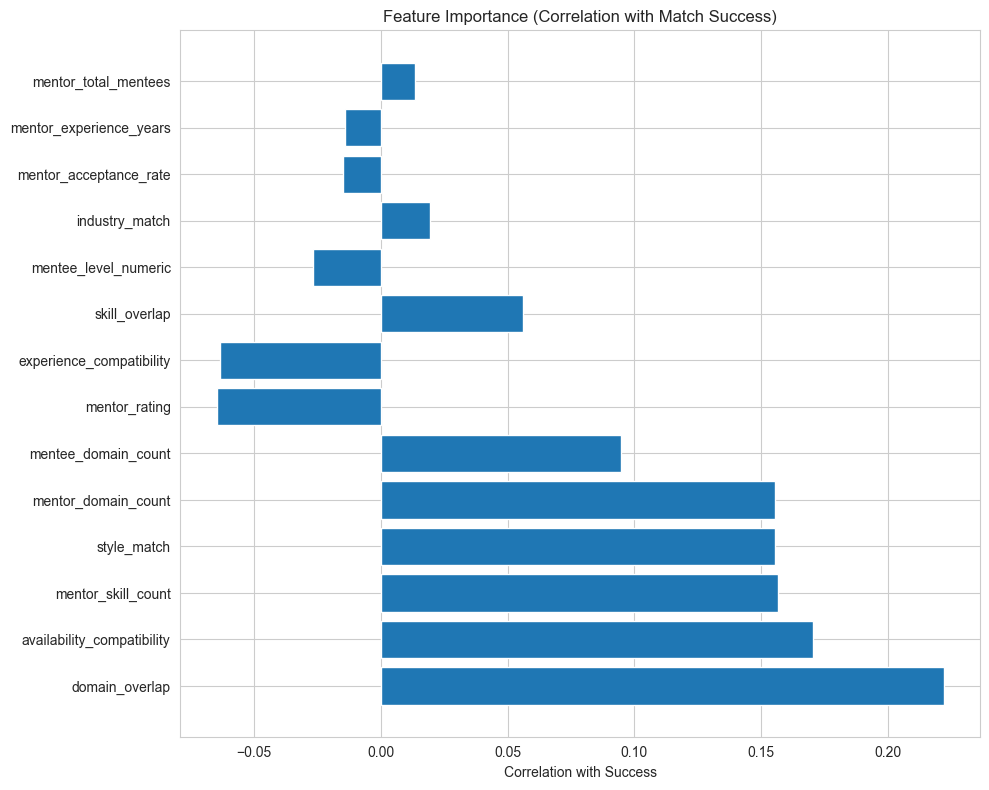

In [12]:
# Analyze feature importance
feature_cols = [col for col in features_df.columns 
                if col not in ['mentor_id', 'mentee_id', 'interaction_id', 'successful_match']]

# Calculate correlation with success
correlations = {}
for col in feature_cols:
    corr = features_df[col].corr(features_df['successful_match'].astype(float))
    correlations[col] = corr

# Sort by absolute correlation
correlations = dict(sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True))

print("Feature Correlations with Success:")

for feature, corr in correlations.items():
    print(f"{feature:35s}: {corr:+.4f}")

# Visualize
plt.figure(figsize=(10, 8))
plt.barh(list(correlations.keys()), list(correlations.values()))
plt.xlabel('Correlation with Success')
plt.title('Feature Importance (Correlation with Match Success)')
plt.tight_layout()
plt.show()

## 3. Train/Test Split & Baseline Model

In [13]:
# Prepare data for modeling
X = features_df[feature_cols]
y = features_df['successful_match'].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nClass distribution in training:")
print(y_train.value_counts())
print(f"\nSuccess rate in training: {y_train.mean():.2%}")
print(f"Success rate in test: {y_test.mean():.2%}")

Training set: 221 samples
Test set: 56 samples

Class distribution in training:
0    129
1     92
Name: successful_match, dtype: int64

Success rate in training: 41.63%
Success rate in test: 41.07%


### Baseline: Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("BASELINE MODEL PERFORMANCE")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Failure', 'Success']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

Training Logistic Regression...
BASELINE MODEL PERFORMANCE

Classification Report:
              precision    recall  f1-score   support

     Failure       0.68      0.85      0.76        33
     Success       0.67      0.43      0.53        23

    accuracy                           0.68        56
   macro avg       0.67      0.64      0.64        56
weighted avg       0.68      0.68      0.66        56


Confusion Matrix:
[[28  5]
 [13 10]]

ROC-AUC Score: 0.7009


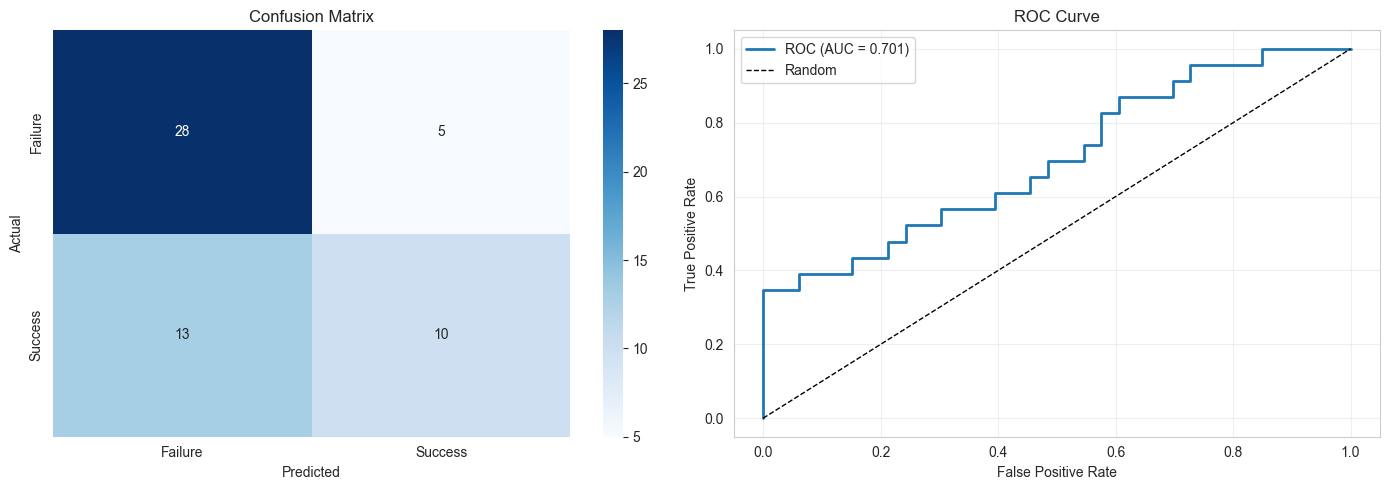

In [15]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')
axes[0].set_xticklabels(['Failure', 'Success'])
axes[0].set_yticklabels(['Failure', 'Success'])

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Feature Importance (Logistic Regression Coefficients):
                   feature  coefficient
            domain_overlap     0.437138
               style_match     0.405249
availability_compatibility     0.220662
             mentor_rating    -0.204820
   mentor_experience_years     0.190659
    mentor_acceptance_rate     0.189133
      mentor_total_mentees     0.187826
       mentee_domain_count     0.137740
  experience_compatibility    -0.134030
       mentor_domain_count     0.109721
            industry_match     0.079098
      mentee_level_numeric    -0.023300
             skill_overlap    -0.016759
        mentor_skill_count     0.015005


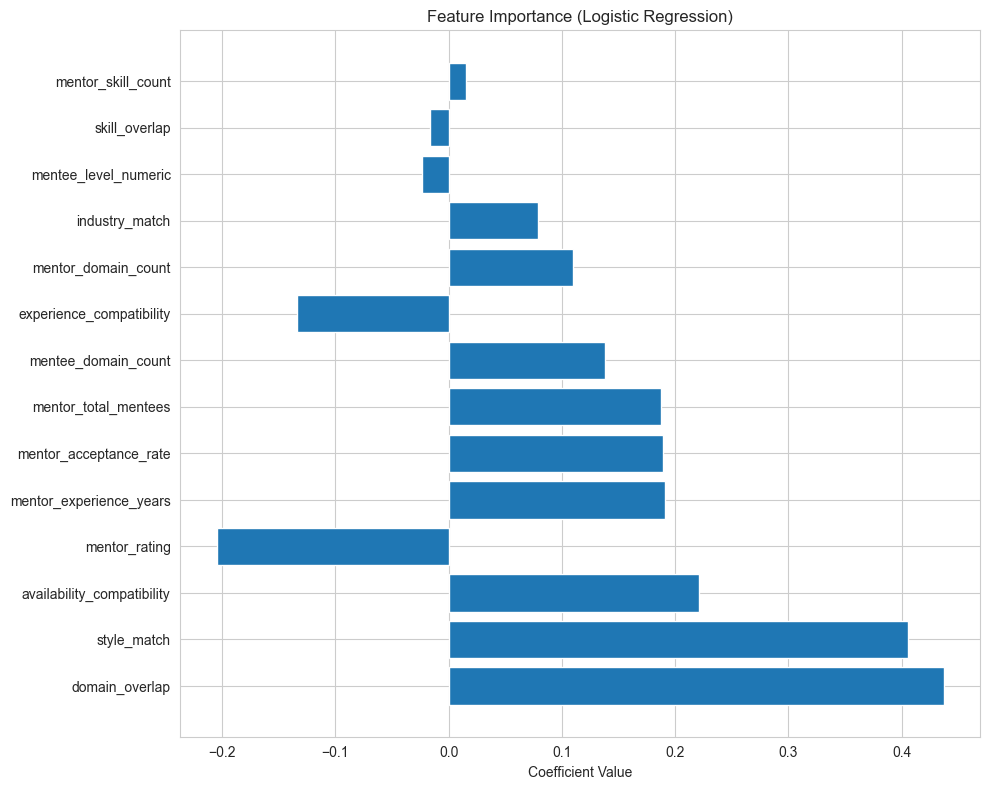

In [16]:
# Feature importance from logistic regression
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):")
print(feature_importance.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Logistic Regression)')
plt.tight_layout()
plt.show()

## 4. Advanced Models

### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("RANDOM FOREST PERFORMANCE")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Failure', 'Success']))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

Training Random Forest...
RANDOM FOREST PERFORMANCE

Classification Report:
              precision    recall  f1-score   support

     Failure       0.61      0.67      0.64        33
     Success       0.45      0.39      0.42        23

    accuracy                           0.55        56
   macro avg       0.53      0.53      0.53        56
weighted avg       0.54      0.55      0.55        56


ROC-AUC Score: 0.5916



Feature Importance (Random Forest):
                   feature  importance
             mentor_rating    0.123407
    mentor_acceptance_rate    0.122046
   mentor_experience_years    0.116751
      mentor_total_mentees    0.114357
availability_compatibility    0.114065
        mentor_skill_count    0.102036
  experience_compatibility    0.054140
               style_match    0.046152
      mentee_level_numeric    0.045285
            domain_overlap    0.043923
       mentor_domain_count    0.041725
       mentee_domain_count    0.029258
             skill_overlap    0.026360
            industry_match    0.020495


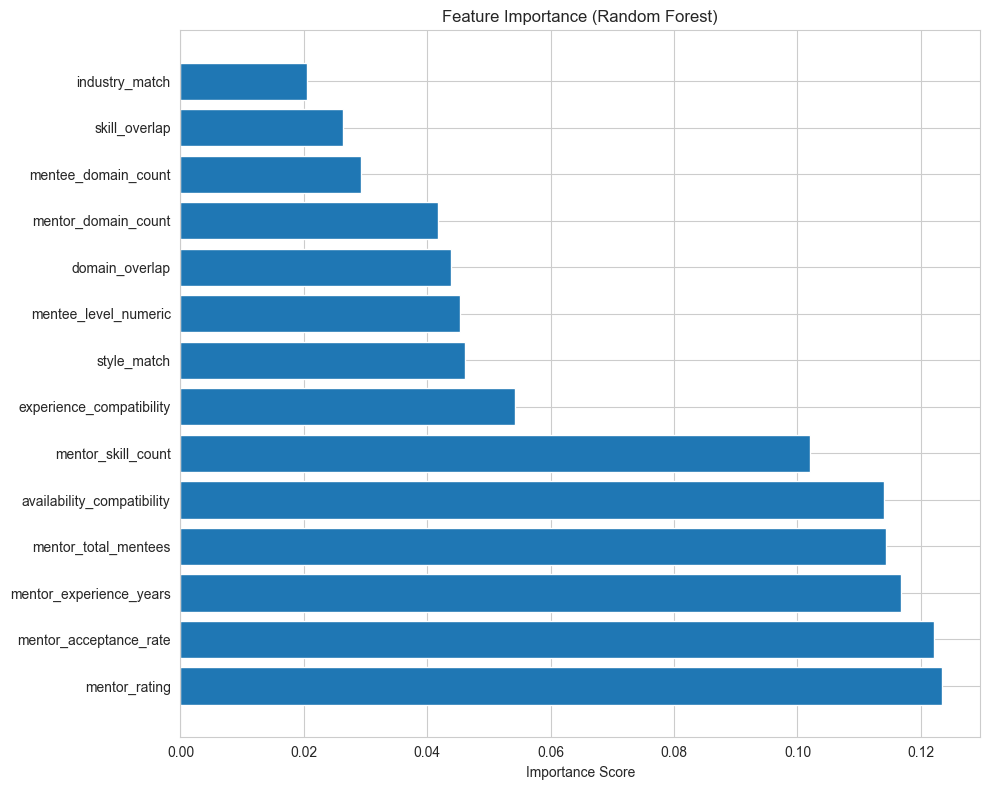

In [18]:
# Feature importance from Random Forest
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(rf_importance.to_string(index=False))

plt.figure(figsize=(10, 8))
plt.barh(rf_importance['feature'], rf_importance['importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()

### Gradient Boosting (XGBoost)

In [19]:
try:
    import xgboost as xgb
    
    print("Training XGBoost...")
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)
    
    # Predictions
    y_pred_xgb = xgb_model.predict(X_test)
    y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
    
    # Evaluation
    print("XGBOOST PERFORMANCE")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_xgb, target_names=['Failure', 'Success']))
    print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
    
except ImportError:
    print("XGBoost not installed. Run: pip install xgboost")

Training XGBoost...
XGBOOST PERFORMANCE

Classification Report:
              precision    recall  f1-score   support

     Failure       0.65      0.61      0.62        33
     Success       0.48      0.52      0.50        23

    accuracy                           0.57        56
   macro avg       0.56      0.56      0.56        56
weighted avg       0.58      0.57      0.57        56


ROC-AUC Score: 0.5797


## 5. Model Comparison

MODEL COMPARISON
              Model  Accuracy  Precision   Recall       F1  ROC-AUC
Logistic Regression  0.678571   0.666667 0.434783 0.526316 0.700922
      Random Forest  0.553571   0.450000 0.391304 0.418605 0.591568
            XGBoost  0.571429   0.480000 0.521739 0.500000 0.579710


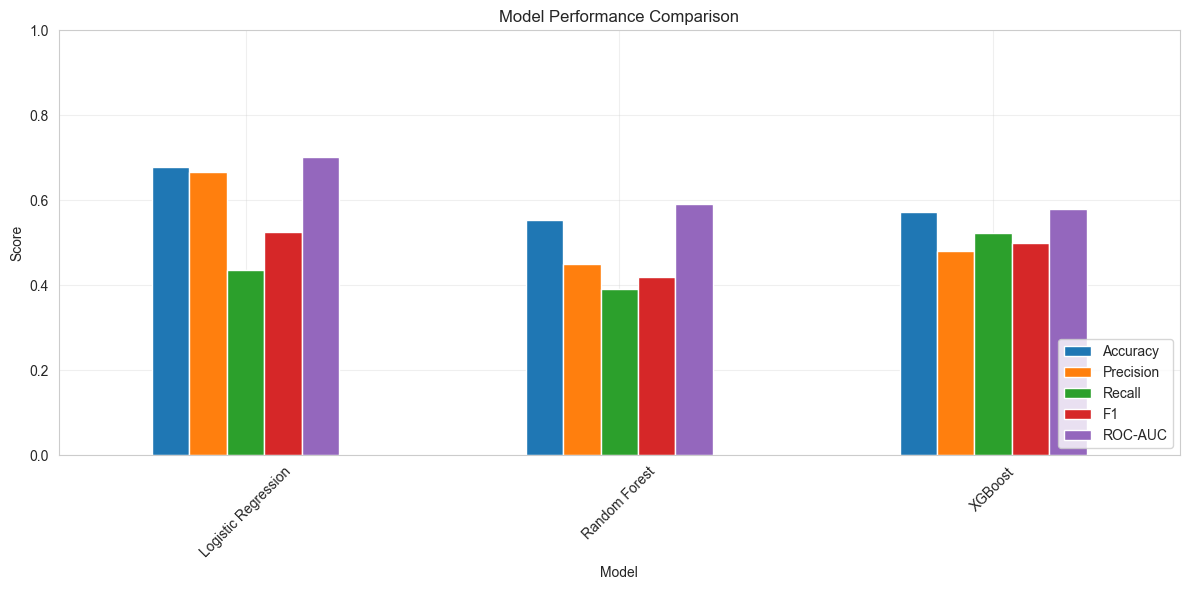

In [20]:
# Compare all models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

results = {
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_rf)
    ],
    'Precision': [
        precision_score(y_test, y_pred),
        precision_score(y_test, y_pred_rf)
    ],
    'Recall': [
        recall_score(y_test, y_pred),
        recall_score(y_test, y_pred_rf)
    ],
    'F1': [
        f1_score(y_test, y_pred),
        f1_score(y_test, y_pred_rf)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_pred_proba),
        roc_auc_score(y_test, y_pred_proba_rf)
    ]
}

try:
    # Add XGBoost if available
    results['Model'].append('XGBoost')
    results['Accuracy'].append(accuracy_score(y_test, y_pred_xgb))
    results['Precision'].append(precision_score(y_test, y_pred_xgb))
    results['Recall'].append(recall_score(y_test, y_pred_xgb))
    results['F1'].append(f1_score(y_test, y_pred_xgb))
    results['ROC-AUC'].append(roc_auc_score(y_test, y_pred_proba_xgb))
except:
    pass

results_df = pd.DataFrame(results)


print("MODEL COMPARISON")

print(results_df.to_string(index=False))

# Visualize comparison
results_df.set_index('Model').plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Making Predictions for New Mentees

Let's create a function to recommend mentors for a new mentee.

In [21]:
def recommend_mentors_for_mentee(mentee_id, top_k=5, model=rf_model):
    """
    Recommend top K mentors for a given mentee
    
    Args:
        mentee_id: ID of the mentee
        top_k: Number of recommendations to return
        model: Trained model to use for predictions
    
    Returns:
        DataFrame with top mentor recommendations and scores
    """
    
    mentee = mentees_df[mentees_df['mentee_id'] == mentee_id].iloc[0]
    
    # Generate features for all active mentors
    recommendations = []
    
    for _, mentor in mentors_df.iterrows():
        # Create feature vector
        features = {
            'domain_overlap': calculate_domain_overlap(mentor['domains'], mentee['desired_domains']),
            'skill_overlap': calculate_skill_overlap(mentor['skills'], mentee.get('current_skills', [])),
            'availability_compatibility': calculate_availability_compatibility(
                mentor['availability_hours'], mentee['availability_hours']
            ),
            'style_match': style_match(mentor['mentorship_style'], mentee['preferred_style']),
            # 'timezone_match': timezone_match(mentor['timezone'], mentee['timezone']),
            'industry_match': industry_match(mentor['industry'], mentee['industry']),
            'mentor_experience_years': mentor['experience_years'],
            'mentor_rating': mentor['rating'],
            'mentor_acceptance_rate': mentor['acceptance_rate'],
            'mentor_total_mentees': mentor['total_mentees'],
            'mentee_level_numeric': {'beginner': 1, 'intermediate': 2, 'advanced': 3}.get(
                mentee['current_level'], 2
            ),
            'experience_compatibility': experience_level_compatibility(
                mentor['experience_years'], mentee['current_level']
            ),
            'mentor_domain_count': len(mentor['domains']) if mentor['domains'] else 0,
            'mentee_domain_count': len(mentee['desired_domains']) if mentee['desired_domains'] else 0,
            'mentor_skill_count': len(mentor['skills']) if mentor['skills'] else 0,
        }
        
        # Predict success probability
        feature_vector = pd.DataFrame([features])[feature_cols]
        success_prob = model.predict_proba(feature_vector)[0][1]
        
        recommendations.append({
            'mentor_id': mentor['mentor_id'],
            'mentor_name': mentor['name'],
            'match_score': success_prob,
            'domains': mentor['domains'],
            'experience_years': mentor['experience_years'],
            'rating': mentor['rating'],
            'domain_overlap': features['domain_overlap'],
            'style_match': features['style_match']
        })
    
    # Sort by match score and return top K
    recommendations_df = pd.DataFrame(recommendations)
    recommendations_df = recommendations_df.sort_values('match_score', ascending=False).head(top_k)
    
    return recommendations_df

print(" Recommendation function created")

 Recommendation function created


In [22]:
# Test the recommendation system
sample_mentee_id = mentees_df.iloc[5]['mentee_id']
sample_mentee = mentees_df[mentees_df['mentee_id'] == sample_mentee_id].iloc[0]

print(f"Mentee: {sample_mentee['name']}")
print(f"Goals: {sample_mentee['goals']}")
print(f"Desired Domains: {sample_mentee['desired_domains']}")
print(f"Current Level: {sample_mentee['current_level']}")


print("TOP 5 MENTOR RECOMMENDATIONS")


recommendations = recommend_mentors_for_mentee(sample_mentee_id, top_k=5, model=rf_model)
print(recommendations.to_string(index=False))

Mentee: Connie Johnson
Goals: Become an expert in Leadership and mentor others
Desired Domains: ['Leadership']
Current Level: advanced
TOP 5 MENTOR RECOMMENDATIONS
 mentor_id         mentor_name  match_score                                   domains  experience_years  rating  domain_overlap  style_match
       387 Christian Jefferson     0.849958        [Marketing, UX Design, Leadership]                 6    3.73             1.0            1
       284         Stacy Flynn     0.807474 [Data Science, Career Development, Sales]                15    4.43             0.0            0
       261        Sarah Garcia     0.805351            [Leadership, Entrepreneurship]                 5    3.24             1.0            0
       369    Carlos Hernandez     0.783350          [Leadership, Business Analytics]                18    4.46             1.0            0
       231     Edward Anderson     0.779351              [UX Design, Cloud Computing]                 5    2.95             0.0    

## 7. Save the Model

In [23]:
import joblib

# Save the best model and scaler
print("Saving model...")
joblib.dump(rf_model, 'mentor_matching_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(feature_cols, 'feature_columns.pkl')

print(" Model saved!")
print("  - mentor_matching_model.pkl")
print("  - feature_scaler.pkl")
print("  - feature_columns.pkl")

Saving model...
 Model saved!
  - mentor_matching_model.pkl
  - feature_scaler.pkl
  - feature_columns.pkl
